<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/trading/btc_dogshit_basket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('slider', 'glue', 'CVXR'), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpQl9nET/remotes80516b8bbd/RWLab-rwRtools-9bce833/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.34.tar.gz’



In [2]:
rwRtools::rwlab_data_auth()

Authorization successful!

## Get perp data

In [3]:
rwRtools:::transfer_lab_object(
      pod = "Crypto",
      object = "ftx_futures_ohlc_1h.feather",
      path = "."
)

futs <- feather::read_feather('ftx_futures_ohlc_1h.feather')
futs <- futs %>% mutate(date = lubridate::as_datetime(date)) %>%
  filter(str_detect(ticker, "-PERP"))

tail(futs)

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ./ftx_futures_ohlc_1h.feather  ( 232.4 M…





File successfully transferred


[1] TRUE

ticker,date,open,high,low,close,volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX-PERP,2022-11-11 19:00:00,0.180225,0.181225,0.178750,0.181225,1227.9917
ZRX-PERP,2022-11-11 20:00:00,0.181225,0.181225,0.177650,0.177650,1274.5441
ZRX-PERP,2022-11-11 21:00:00,0.177650,0.180725,0.177650,0.180650,966.6679
ZRX-PERP,2022-11-11 22:00:00,0.180650,0.181950,0.180475,0.181950,263.9651
ZRX-PERP,2022-11-11 23:00:00,0.181950,0.181950,0.180775,0.181925,884.3130
ZRX-PERP,2022-11-12 00:00:00,0.181925,0.182625,0.181550,0.181700,106.2685


`summarise()` has grouped output by 'ticker'. You can override using the
`.groups` argument.


ticker,date,open,high,low,close,volume
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ZRX-PERP,2022-11-07,0.256250,0.263350,0.25110,0.258050,7.735182e+05
ZRX-PERP,2022-11-08,0.258050,0.261650,0.19185,0.210100,1.739116e+07
ZRX-PERP,2022-11-09,0.210100,0.213425,0.15965,0.163425,2.691925e+06
ZRX-PERP,2022-11-10,0.163425,0.196250,0.15965,0.188800,6.549381e+05
ZRX-PERP,2022-11-11,0.188800,0.196450,0.17155,0.181925,1.322139e+05
ZRX-PERP,2022-11-12,0.181925,0.182625,0.18155,0.181700,1.062685e+02


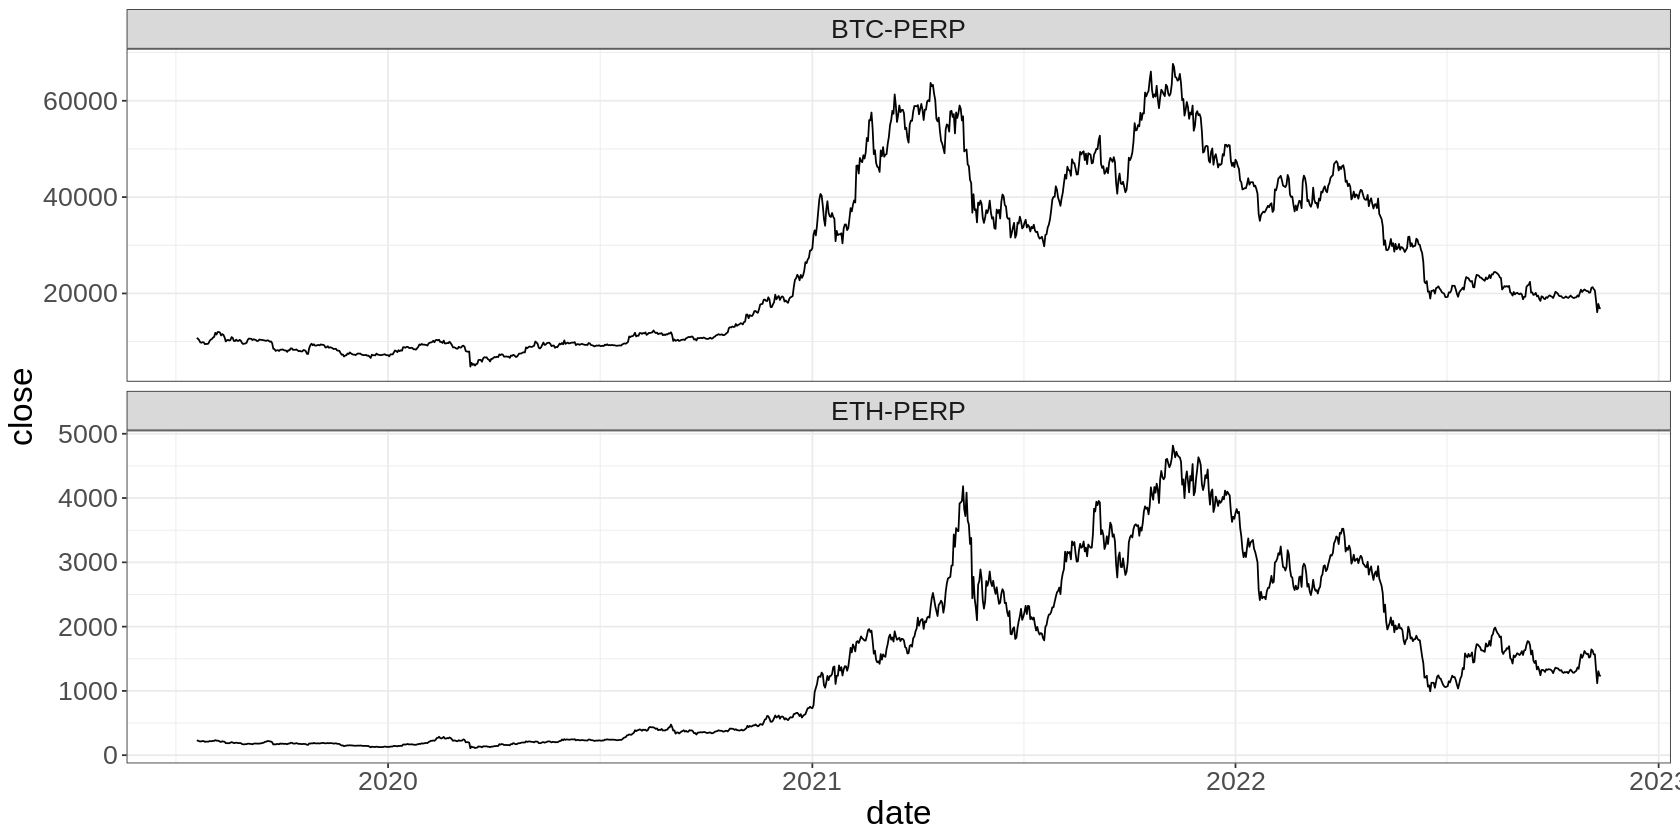

In [4]:
# make daily OHLCV (UTC midnight - UTC midnight)
daily_futs <- futs %>%
  separate(date, into = c("date", "time"), sep = " ") %>%
  group_by(ticker, date) %>%
  summarise(
    open = first(open),
    high = max(high),
    low = min(low),
    close = last(close),
    volume = sum(volume)
  ) %>%
  mutate(date = as_date(date))

tail(daily_futs)

daily_futs %>%
  filter(ticker %in% c("BTC-PERP", "ETH-PERP")) %>%
  ggplot(aes(x = date, y = close)) +
    geom_line() +
    facet_wrap(~ticker, ncol = 1, scales = "free_y")

## Make returns

In [5]:
returns <- daily_futs %>%
  group_by(ticker) %>%
  arrange(date) %>%
  select(ticker, date, close) %>%
  mutate(log_return = log(close / lag(close, n = 1))) %>%
  mutate(simple_return = close / lag(close, n = 1) - 1) %>%
  na.omit() %>%
  ungroup()

tail(returns)

ticker,date,close,log_return,simple_return
<chr>,<date>,<dbl>,<dbl>,<dbl>
XTZ-PERP,2022-11-12,1.01570,0.024013509,0.024304155
YFI-PERP,2022-11-12,6195.00000,0.029486166,0.029925187
YFII-PERP,2022-11-12,1745.00000,-0.010829402,-0.010770975
ZEC-PERP,2022-11-12,39.18000,-0.005091661,-0.005078720
ZIL-PERP,2022-11-12,0.02186,0.009191241,0.009233610
ZRX-PERP,2022-11-12,0.18170,-0.001237539,-0.001236773


Ditch stuff we wouldn't trade:

Any others? Probably get rid of the non-shit ones. (ETH, LTC etc)



In [6]:
to_ditch = c('CUSDT-PERP','USDT-PERP','BRZ-PERP','XAUT-PERP','TRYB-PERP','AMPL-PERP')
returns <- returns %>%
  filter(!ticker %in% to_ditch)

## Calculate beta to BTC

$\beta = \frac{Cov(R_{BTC}, R_{dogshit})}{Var(R_{BTC}}$

In [7]:
# make a long df with the btc-perp return in a column
beta_returns <- returns %>%
  # filter(ticker %in% c("BTC-PERP", "ETH-PERP", "LTC-PERP")) %>%
  select(ticker, date, log_return) %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = log_return) %>%
  pivot_longer(cols = c(-date, -`BTC-PERP`), names_to = "ticker", values_to = "log_return") %>%
  rename("BTC_return" = `BTC-PERP`)

tail(beta_returns)

date,BTC_return,ticker,log_return
<date>,<dbl>,<chr>,<dbl>
2022-11-12,-0.001892372,FTXDXY-PERP,0.0000000000
2022-11-12,-0.001892372,APT-PERP,0.0079712934
2022-11-12,-0.001892372,KLAY-PERP,0.0046911736
2022-11-12,-0.001892372,INJ-PERP,-0.0006015942
2022-11-12,-0.001892372,JPY-PERP,-0.0298198366
2022-11-12,-0.001892372,MASK-PERP,0.0025848916


In [8]:
# BTC variance
var_btc <- beta_returns %>%
  select(date, BTC_return) %>%
  distinct() %>%
  pull(BTC_return) %>%
  var()

var_btc

[1] 0.001571818

In [9]:
# calculate beta of everything to BTC
# "pairwise.complete.obs" uses complete observations for each pair of variables
beta <- beta_returns %>%
  group_by(ticker) %>%
  summarise(beta = cov(BTC_return, log_return, use = "pairwise.complete.obs")/var_btc) %>%
  bind_rows(data.frame(ticker = "BTC-PERP", beta = 1)) %>%
  arrange(desc(beta))

head(beta)

ticker,beta
<chr>,<dbl>
MASK-PERP,5.982726
INJ-PERP,3.781378
APT-PERP,3.313235
KLAY-PERP,2.945787
OP-PERP,1.517170
LOOKS-PERP,1.440509


## Approach 1

One way to sovle this problem is to pick a basket of dogshit, assume an equal beta-contribution, and then fudge the weights so that the sum of the betas is minus 1, ensuring that stuff with a higher absolute beta gets a lower weight:

(betas are additive in the portfolio sense)

In [10]:
to_trade <- c('UNISWAP-PERP', 'MANGO-PERP', 'MAPS-PERP', 'POLIS-PERP', 'OXY-PERP', 'FIDA-PERP', 'BADGER-PERP', 'RON-PERP', 'CEL-PERP', 
'AUDIO-PERP', 'SPELL-PERP', 'ALPHA-PERP', 'DEFI-PERP', 'SHIT-PERP', 'OMG-PERP', 'OP-PERP', 'GAL-PERP', 'GST-PERP', 'ALGO-PERP', 'JASMY-PERP')


$\beta_{port} = \sum w_i*\beta_i$

$w_i = \frac{-1}{\beta_i*n}$


In [11]:
equal_beta_weight <- beta %>%
  filter(ticker %in% to_trade) %>%
  # set OP and MANGO beta to 1 - don't have data
  bind_rows(
    data.frame(
      ticker = c("OP-PERP", "MANGO-PERP"),
      beta = c(1)
    )
  ) %>%
  mutate(
    weight = -1/(beta*n()), 
    beta_contib = weight*beta
  ) %>%
  arrange(ticker)

equal_beta_weight

ticker,beta,weight,beta_contib
<chr>,<dbl>,<dbl>,<dbl>
ALGO-PERP,1.1058085,-0.04306265,-0.04761905
ALPHA-PERP,1.2798730,-0.03720607,-0.04761905
AUDIO-PERP,1.2369022,-0.03849864,-0.04761905
BADGER-PERP,1.3860789,-0.03435522,-0.04761905
CEL-PERP,0.8054455,-0.05912138,-0.04761905
DEFI-PERP,1.0167004,-0.04683685,-0.04761905
FIDA-PERP,1.0148656,-0.04692153,-0.04761905
GAL-PERP,1.1835984,-0.04023244,-0.04761905
GST-PERP,0.7914224,-0.06016894,-0.04761905


What's the allocation to this basket of dogshit (the stuff we're shorting) to achieve beta-neutrality?

In [12]:
equal_beta_weight %>%
  summarise(sum(weight))

sum(weight)
<dbl>
-0.9704963


We can do it with leverage < 1 as many of these shitcoins have a beta > 1

## Approach 2

Can pose this as an optimisation problem:
- Find the weights that maximise return and minimise variance given
  - basket is beta neutral 
  - BTC weight is 1
  - other weights < 1

Maybe start with just maximising returns, don't worry about portfolio variance 

In [13]:
to_trade <- c('BTC-PERP', to_trade)

In [14]:
returns_vec <- returns %>%
  filter(ticker %in% to_trade) %>%
  select(date, ticker, log_return) %>%
  group_by(ticker) %>%
  summarise(returns = sum(log_return)) 

returns_vec

ticker,returns
<chr>,<dbl>
ALGO-PERP,-0.8336573
ALPHA-PERP,-1.4476024
AUDIO-PERP,-3.1250166
BADGER-PERP,-2.9833919
BTC-PERP,0.4505887
CEL-PERP,-2.4319016
DEFI-PERP,0.6258440
FIDA-PERP,-2.5463502
GAL-PERP,-2.4530858


In [15]:
betas_vec <- beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%  #important so that they're in the same order as returns 
  arrange(ticker)

betas_vec

ticker,beta
<chr>,<dbl>
ALGO-PERP,1.1058085
ALPHA-PERP,1.2798730
AUDIO-PERP,1.2369022
BADGER-PERP,1.3860789
BTC-PERP,1.0000000
CEL-PERP,0.8054455
DEFI-PERP,1.0167004
FIDA-PERP,1.0148656
GAL-PERP,1.1835984


In [16]:
btc_idx <- which(betas_vec$ticker == "BTC-PERP")
btc_idx

[1] 5

In [17]:
cov_mat <- returns %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  select(date, ticker, log_return) %>%
  pivot_wider(date, names_from = ticker, values_from = log_return) %>%
  na.omit() %>%
  select(-date) %>%
  data.matrix() %>%
  cov()

cov_mat[1:3, 1:3]

Warning message:
“Specifying the `id_cols` argument by position was deprecated in tidyr 1.3.0.
ℹ Please explicitly name `id_cols`, like `id_cols = date`.”


,ALGO-PERP,ALPHA-PERP,AUDIO-PERP
ALGO-PERP,0.002499715,0.002314597,0.002115682
ALPHA-PERP,0.002314597,0.003502954,0.002417366
AUDIO-PERP,0.002115682,0.002417366,0.002907073


In [18]:
returns_vec <- returns_vec$returns
betas_vec <- betas_vec$beta

In [19]:
# trivial case to replicate equal beta contribution above
# maximise historical returns but have hard constraint on equal beta contribution

beta_contrib <- -1/(betas_vec*(length(betas_vec) - 1))  # less one because we have BTC-PERP

weights <- Variable(rows = length(returns_vec))
objective <- Maximize(t(weights) %*% returns_vec)
constraints <- list(weights[btc_idx] == 1, weights[-btc_idx] == beta_contrib[-btc_idx])
problem <- Problem(objective, constraints)
result <- solve(problem)

w <- result$getValue(weights)
w

-0.04759556
-0.04112250
-0.04255112
-0.03797156
1.00000000
-0.06534468
-0.05176705
-0.05186064
-0.04446743
-0.06650251
-0.06530408


In [20]:
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w)

# total net beta
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w) %>%
  summarise(net_beta = sum(beta*weight))

# total allocation
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w) %>%
  summarise(total_alloaction = sum(weight))

ticker,beta,weight
<chr>,<dbl>,"<dbl[,1]>"
ALGO-PERP,1.1058085,-0.04759556
ALPHA-PERP,1.2798730,-0.04112250
AUDIO-PERP,1.2369022,-0.04255112
BADGER-PERP,1.3860789,-0.03797156
BTC-PERP,1.0000000,1.00000000
CEL-PERP,0.8054455,-0.06534468
DEFI-PERP,1.0167004,-0.05176705
FIDA-PERP,1.0148656,-0.05186064
GAL-PERP,1.1835984,-0.04446743


net_beta
<dbl>
2.775558e-17


total_alloaction
<dbl>
0.0326094


In [21]:
# maximise historical returns less sum of betas
# ie treat beta of basket as a soft constraint

weights <- Variable(rows = length(returns_vec))
objective <- Maximize(t(weights) %*% returns_vec - abs(sum(multiply(weights, betas_vec))))
constraints <- list(weights[btc_idx] == 1, weights[-btc_idx] <= 0, sum(weights[-btc_idx]) == -1)
problem <- Problem(objective, constraints)
result <- solve(problem)

w <- result$getValue(weights)
w

1.874484e-22
-1.345651e-22
-3.045252e-23
-8.216897e-23
1.000000e+00
-2.775552e-23
8.257999e-23
1.379614e-22
-2.990452e-23
-2.168398e-23
-2.775552e-23


In [22]:
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w)

ticker,beta,weight
<chr>,<dbl>,"<dbl[,1]>"
ALGO-PERP,1.1058085,1.874484e-22
ALPHA-PERP,1.2798730,-1.345651e-22
AUDIO-PERP,1.2369022,-3.045252e-23
BADGER-PERP,1.3860789,-8.216897e-23
BTC-PERP,1.0000000,1.000000e+00
CEL-PERP,0.8054455,-2.775552e-23
DEFI-PERP,1.0167004,8.257999e-23
FIDA-PERP,1.0148656,1.379614e-22
GAL-PERP,1.1835984,-2.990452e-23


This gets us a fully short position in only a single ticker, and it's not beta-neutral to BTC (slightly net short).

In [23]:
# maximise historical returns but treat beta of basket as a hard constraint

weights <- Variable(rows = length(returns_vec))
objective <- Maximize(t(weights) %*% returns_vec)
constraints <- list(weights[btc_idx] == 1, weights[-btc_idx] <= 0, sum(weights[-btc_idx]) == -1, sum(multiply(weights, betas_vec)) == 0)
problem <- Problem(objective, constraints)
result <- solve(problem)

w <- result$getValue(weights)
w

-7.642268e-25
5.230374e-23
-6.689709e-23
2.662936e-23
1.000000e+00
-5.115735e-24
-8.147917e-23
-1.361953e-22
-2.502065e-23
-3.315037e-01
-5.298327e-24


In [24]:
# portfolio weights and betas
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w)

# total net beta
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w) %>%
  summarise(net_beta = sum(beta*weight))

# total allocation
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w) %>%
  summarise(total_alloaction = sum(weight))

ticker,beta,weight
<chr>,<dbl>,"<dbl[,1]>"
ALGO-PERP,1.1058085,-7.642268e-25
ALPHA-PERP,1.2798730,5.230374e-23
AUDIO-PERP,1.2369022,-6.689709e-23
BADGER-PERP,1.3860789,2.662936e-23
BTC-PERP,1.0000000,1.000000e+00
CEL-PERP,0.8054455,-5.115735e-24
DEFI-PERP,1.0167004,-8.147917e-23
FIDA-PERP,1.0148656,-1.361953e-22
GAL-PERP,1.1835984,-2.502065e-23


net_beta
<dbl>
-1.665336e-16


total_alloaction
<dbl>
-1.110225e-16


This approach gets into an additional position, and net beta is zero.

Another approach would be to maximise $return - variance$, subject to a hard beta-neutrality constraint. 

Idea would be to force some non-zero weights on some other usefully uncorrelated assets in the basket. 

Need to tune the lambda parameter for this one. 

In [25]:
lambda <- 500

weights <- Variable(rows = length(returns_vec))
objective <- Maximize(t(weights) %*% returns_vec - lambda*quad_form(weights, cov_mat))
# constraints <- list(sum(weights) == 0)
constraints <- list(weights[btc_idx] == 1, weights[-btc_idx] <= 0, sum(weights[-btc_idx]) == -1, sum(multiply(weights, betas_vec)) == 0)
problem <- Problem(objective, constraints)
result <- solve(problem)

w <- result$getValue(weights)
w

-5.001304e-23
-1.489230e-22
-8.710504e-02
-1.586736e-01
1.000000e+00
6.840573e-23
2.071371e-22
8.974297e-23
1.360059e-22
-1.551253e-01
9.389669e-23


In [26]:
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w)

ticker,beta,weight
<chr>,<dbl>,"<dbl[,1]>"
ALGO-PERP,1.1058085,-5.001304e-23
ALPHA-PERP,1.2798730,-1.489230e-22
AUDIO-PERP,1.2369022,-8.710504e-02
BADGER-PERP,1.3860789,-1.586736e-01
BTC-PERP,1.0000000,1.000000e+00
CEL-PERP,0.8054455,6.840573e-23
DEFI-PERP,1.0167004,2.071371e-22
FIDA-PERP,1.0148656,8.974297e-23
GAL-PERP,1.1835984,1.360059e-22


This spreads some allocation around the basket a little more. 

Check beta-neutrality:

In [27]:
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w) %>%
  summarise(port_beta = sum(weight*beta))

port_beta
<dbl>
-3.469446e-17


In [28]:
# total allocation
beta %>%
  filter(ticker %in% to_trade) %>%
  arrange(ticker) %>%
  mutate(weight = w) %>%
  summarise(total_alloaction = sum(weight))

total_alloaction
<dbl>
-9.714451e-17


Thing to note here is that returns, betas, covariances are all calculated on historical data. So you don't want to kid yourself that this approach will lead to any sort of precision out of sample. 

It's probably no better than allocating an equal-beta weight to everything in the basket...

Also I don't really like this approach for this application because the main goal isn't minimising variance... it's diversifying across as many dogshit coins as possible.